In [228]:
# import packages
import numpy as np
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from sklearn.preprocessing import normalize
import pandas as pd
import os
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [229]:
def load_images_from_folder(folder_path, target_size=(200, 200), color_mode='RGB'):
    images = []
    original_images = []  
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path).convert(color_mode)  
            img_resized = img.resize(target_size)  
            images.append(np.array(img_resized).flatten())  
            original_images.append(np.array(img_resized)) 
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images), np.array(original_images) 


In [230]:
def normalize_channels(images):
    n_samples, flattened_size = images.shape 
    side_length = int(np.sqrt(flattened_size // 3))  
    images_reshaped = images.reshape((n_samples, side_length, side_length, 3)) 
    
    height, width = images_reshaped.shape[1], images_reshaped.shape[2]

    r_channel = images_reshaped[..., 0]
    g_channel = images_reshaped[..., 1]
    b_channel = images_reshaped[..., 2]

    r_channel = r_channel / 255.0
    g_channel = g_channel / 255.0
    b_channel = b_channel / 255.0

    return r_channel, g_channel, b_channel, height, width


In [231]:
def perform_pca_on_channel(channel_data, n_components):
    n_samples, height, width = channel_data.shape 
    channel_flattened = channel_data.reshape((n_samples, height*width))  
    
    channel_mean = np.mean(channel_flattened, axis=0)
    channel_centered = channel_flattened - channel_mean

    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(channel_centered) 
    principal_components = pca.components_

    return Z, principal_components, channel_mean


In [232]:
def reconstruct_channel(Z, principal_components, channel_mean, height, width):
    reconstructed_flattened = np.dot(Z, principal_components) + channel_mean

    reconstructed_channel = reconstructed_flattened.reshape((-1, height, width))

    return reconstructed_channel


In [233]:
def combine_channels(r, g, b):
    reconstruct_rgb = np.stack((r, g, b), axis=1).transpose(0, 2, 3, 1)

    return reconstruct_rgb


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 199.5, 199.5, -0.5)

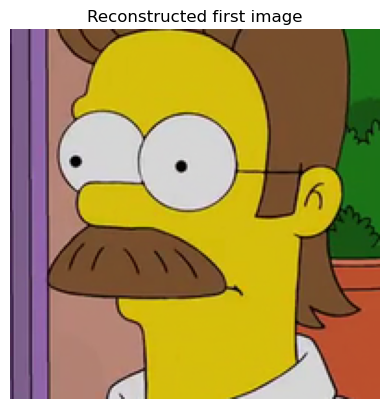

In [380]:
folder_path = "10_per_char"
simpsons_rgb, simpsons_original_rgb = load_images_from_folder(folder_path, target_size=(200, 200))

r_channel, g_channel, b_channel, height, width = normalize_channels(simpsons_rgb)

n_components = 50 #(make bigger for shraper image, but it will run slower)

r_Z, r_principal_components, r_channel_mean = perform_pca_on_channel(r_channel, n_components)
g_Z, g_principal_components, g_channel_mean = perform_pca_on_channel(g_channel, n_components)
b_Z, b_principal_components, b_channel_mean = perform_pca_on_channel(b_channel, n_components)

r_reconstructed = reconstruct_channel(r_Z, r_principal_components, r_channel_mean, height, width)
g_reconstructed = reconstruct_channel(g_Z, g_principal_components, g_channel_mean, height, width)
b_reconstructed = reconstruct_channel(b_Z, b_principal_components, b_channel_mean, height, width)

reconstructed_rgb = combine_channels(r_reconstructed, g_reconstructed, b_reconstructed)

plt.imshow(reconstructed_rgb[0])
plt.title("Reconstructed first image")
plt.axis('off')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


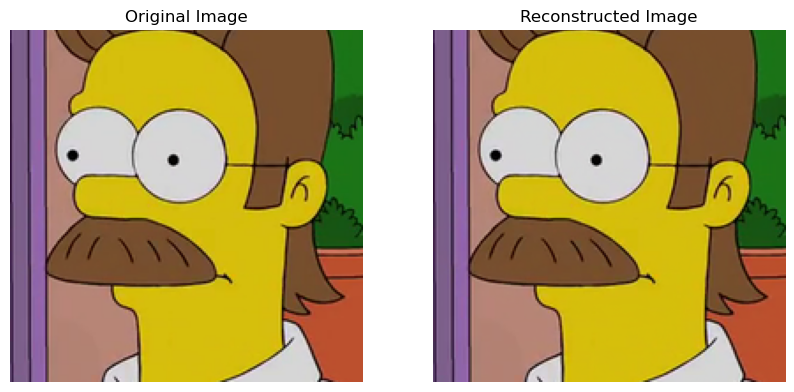

In [381]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(simpsons_original_rgb[0])
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(reconstructed_rgb[0])
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')
plt.show()


In [514]:
def combine_channels_for_clustering(r_Z, g_Z, b_Z, top_k):
    r_Z_top = r_Z[:, :top_k]
    g_Z_top = g_Z[:, :top_k]
    b_Z_top = b_Z[:, :top_k]
    
    combined_data = np.hstack((r_Z_top, g_Z_top, b_Z_top))
    return combined_data

top_k = 10
combined_Z = combine_channels_for_clustering(r_Z, g_Z, b_Z, top_k)
print(f"Combined PCA feature matrix shape (after top components): {combined_Z.shape}")


Combined PCA feature matrix shape (after top components): (50, 30)


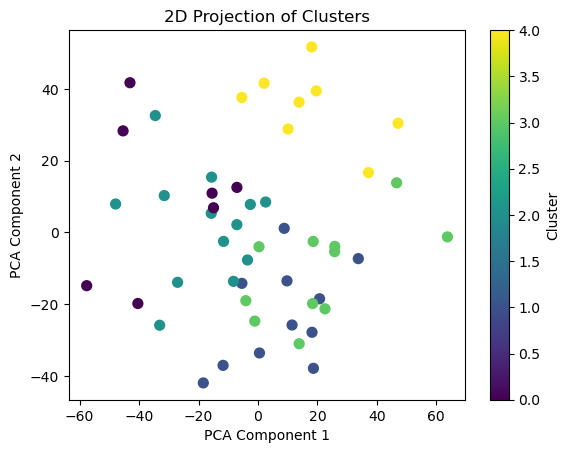

In [515]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(combined_Z)

pca_2d = PCA(n_components=3)
pca_2d_features = pca_2d.fit_transform(combined_Z)

plt.scatter(pca_2d_features[:, 0], pca_2d_features[:, 1], c=clusters, cmap='viridis', s=50)
plt.title("2D Projection of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [516]:
from sklearn.metrics import silhouette_score
score = silhouette_score(combined_Z, clusters)
print(f"Silhouette Score: {score}")


Silhouette Score: 0.07136716524792926


In [517]:
def plot_images_from_cluster(cluster_idx, images, labels, target_size=(200, 200)):
    cluster_images_idx = np.where(labels == cluster_idx)[0]
    
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(cluster_images_idx[:10]):  # Show up to 10 images
        ax = plt.subplot(5, 5, i + 1)
        image_to_plot = images[idx]
        
        if image_to_plot.ndim == 1:  # Reshape if flattened
            image_to_plot = image_to_plot.reshape(target_size[0], target_size[1], 3)
        
        ax.imshow(image_to_plot)
        ax.axis('off')
    
    plt.suptitle(f"Cluster {cluster_idx + 1} Images")
    plt.show()


In [518]:
print(simpsons_original_rgb[0].shape)


(200, 200, 3)


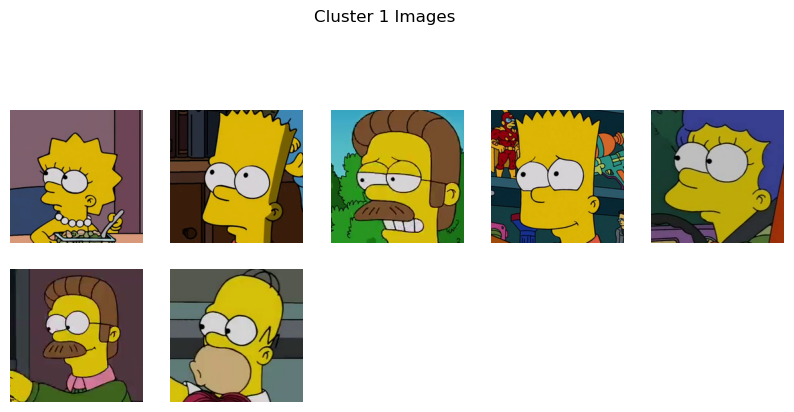

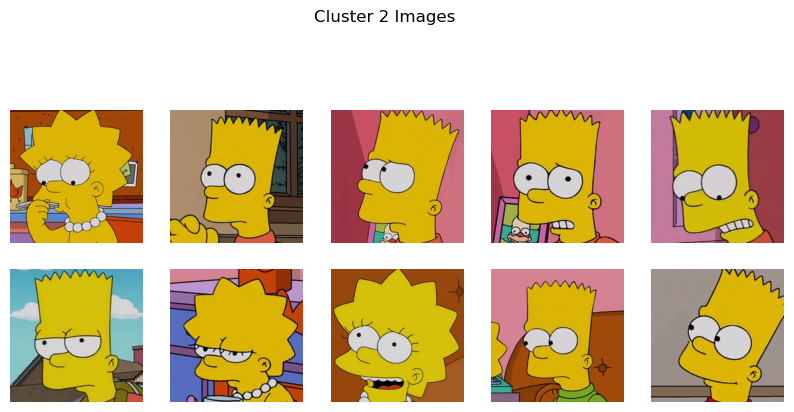

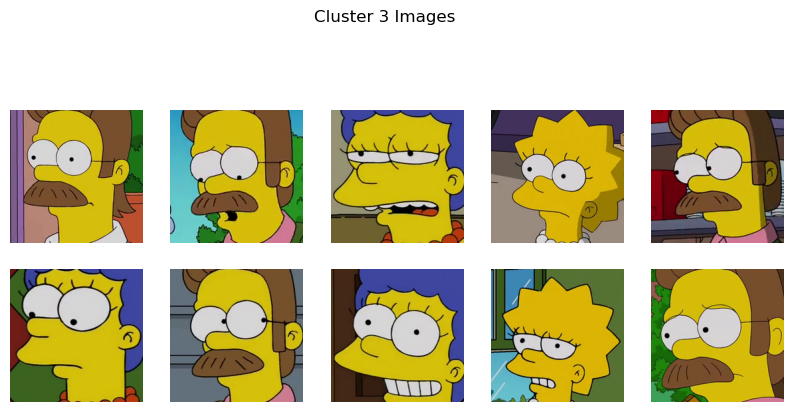

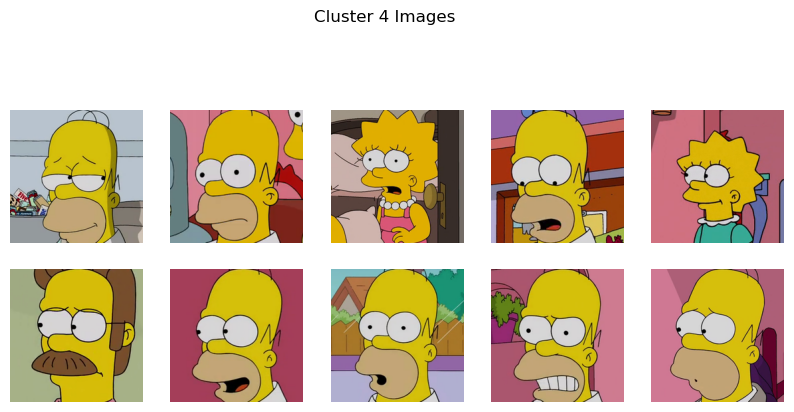

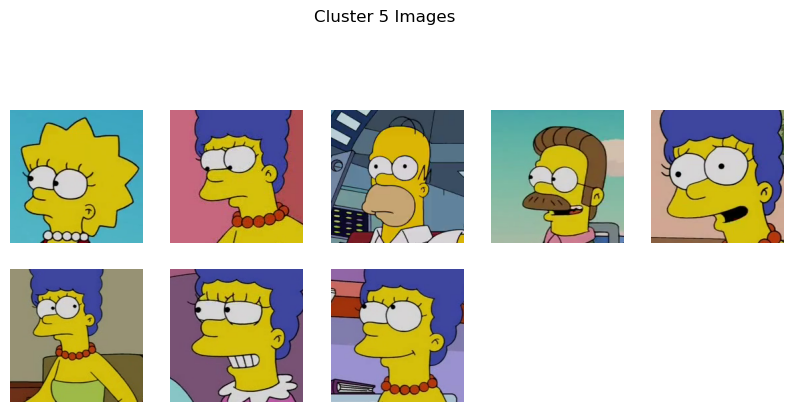

In [519]:
for cluster_idx in range(n_clusters):
    plot_images_from_cluster(cluster_idx, simpsons_rgb, clusters)


In [487]:
from sklearn.metrics import silhouette_score
score = silhouette_score(combined_Z, clusters)
print(f"Silhouette Score: {score}")


Silhouette Score: 0.14846403174010447


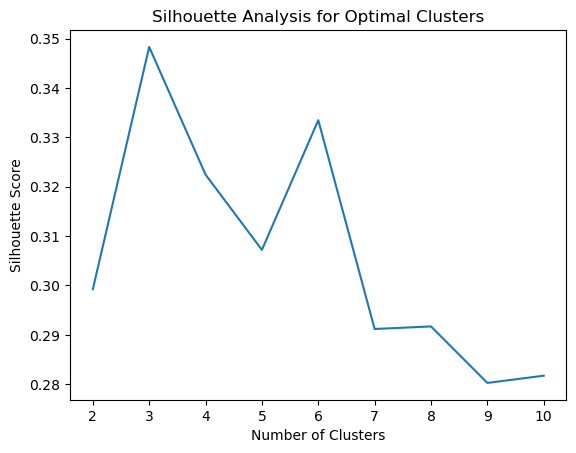

In [459]:
silhouette_scores = []
for k in range(2, 11):  # Test from 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(combined_Z)
    silhouette_avg = silhouette_score(combined_Z, clusters)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores for each k
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Clusters')
plt.show()
